# LVIS dataset
## Overview
Some overview here

## Learning Objectives

## Datasets

## Requirements
1. Compute environment
This notebook can be run in any personal computing environment (e.g., desktop/laptops), on-premise solution (e.g., High-Performance Computing), or on the Cloud (e.g., Amazon Web Service).

2. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

3. Additional Requirements
While NASA’s Harmony services are available directly through RESTful API, we will use Harmony-Py Python library for this tutorial. Harmony-Py provides a friendly interface for integrating with NASA’s Harmony Services. In addition to Harmony-Py, this tutorial requires the following Python modules installed in your system: earthaccess, pandas, geopandas, contextily.

```
pip install -U earthaccess, pandas, geopandas, contextily
```

## Import modules

In [1]:
import linecache
from glob import glob
import pandas as pd
import earthaccess
import geopandas as gpd
import contextily as cx
from shapely.ops import orient
from shapely.geometry import Polygon, MultiPolygon

## Authentication
We recommend authenticating your Earthdata Login (EDL) information using the earthaccess python library as follows:

In [2]:
# works if the EDL login already been persisted to a netrc
auth = earthaccess.login(strategy="netrc") 
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## LVIS Full-waveform Lidar
Land, Vegetation, and Ice Sensor (LVIS), is an airborne, wide-swath imaging full-waveform laser altimeter. LVIS collects in a 1064 nm-wavelength (near infrared) range with 3 detectors mounted in an airborne platform, flown typically ~10 km above the ground producing a data swath of 2km wide with 7-10 m footprints. More information about the LVIS instrument is [here](https://lvis.gsfc.nasa.gov/Home/instrumentdetails.html).

The LVIS instrument has been flown above several regions of the world since 1998. The LVIS flights were collected for the [BioSCAPE campaigns](https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html) from `01 Oct 2023` through `30 Nov 2023`.

There are three LVIS data products currently available and archived at [NSIDC DAAC](https://nsidc.org/data/lvis):

| Dataset | Dataset DOI | 
| -------- | --- |
| LVIS L1A Geotagged Images V001 | [10.5067/NE5KKKBAQG44](https://doi.org/10.5067/NE5KKKBAQG44) |
| LVIS Facility L1B Geolocated Return Energy Waveforms V001 | [10.5067/XQJ8PN8FTIDG](https://doi.org/10.5067/XQJ8PN8FTIDG) |
| LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001 | [10.5067/VP7J20HJQISD](https://doi.org/10.5067/VP7J20HJQISD) |

## Search LVIS granules over Bioscape Campaign
We will use `earthaccess` module to search and download LVIS data. 

In [3]:
granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi="10.5067/VP7J20HJQISD", # LVIS L2A doi
    temporal=("2023-10-01", "2023-11-30"), # Bioscape campaign dates
)

Granules found: 2328


There are `2328` granules LVIS L1B product found for the time period. Let's see if they are hosted on Earthdata cloud or not, by printing a summary of the first granule.

In [4]:
granules[0]

Collection: {'EntryTitle': 'LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 19.33306, 'Latitude': -32.96526}, {'Longitude': 19.32879, 'Latitude': -32.96885}, {'Longitude': 19.2562, 'Latitude': -33.02265}, {'Longitude': 19.17507, 'Latitude': -33.08003}, {'Longitude': 19.09821, 'Latitude': -33.13742}, {'Longitude': 19.10248, 'Latitude': -33.15894}, {'Longitude': 19.15372, 'Latitude': -33.13383}, {'Longitude': 19.22631, 'Latitude': -33.07645}, {'Longitude': 19.30317, 'Latitude': -33.02265}, {'Longitude': 19.36722, 'Latitude': -32.97603}, {'Longitude': 19.36295, 'Latitude': -32.96166}, {'Longitude': 19.33733, 'Latitude': -32.96166}, {'Longitude': 19.33306, 'Latitude': -32.96526}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-20T07:36:13.511Z', 'EndingDateTime': '2023-10-20T07:38:46.605Z'}}
Size(MB): 128.175
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF2.001/2023.10.20/LVISF2_BioSCape2023_1020_R2404_027373.TXT']

As we see above, the LVIS files are not cloud-hosted yet. They have to be downloaded locally and use them.

## Plot LVIS Bioscape Campaigns
Lets first define two functions that we can use to plot the search results above over a basemap.

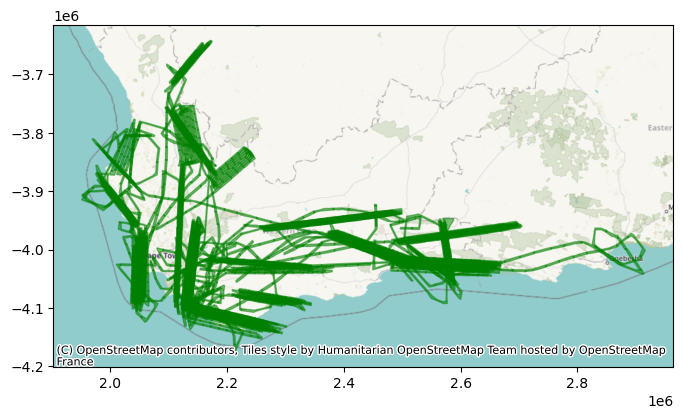

In [5]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    
gdf = convert_list_gdf(granules)
ax = gdf.to_crs(epsg=3857).plot(figsize=(8, 6), alpha=0.5, facecolor='g', edgecolor="g")
cx.add_basemap(ax)

## Study Area
The study area is [Brackenburn Private Nature Reserve](https://plcnetwork.co.za/member/121/Brackenburn-Private-Nature-Reserve/)

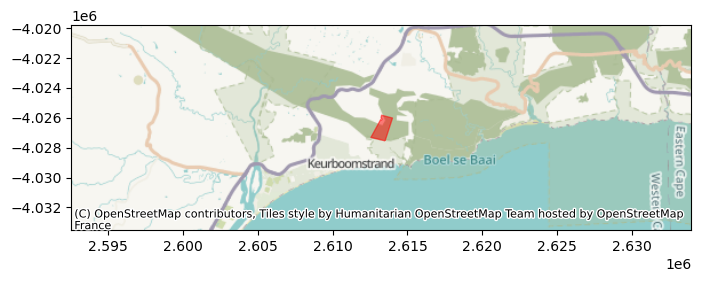

In [6]:
poly = gpd.read_file("data/brackenburn.json")
ax = poly.to_crs(epsg=3857).plot(figsize=(8, 6), alpha=0.5, facecolor='r',  edgecolor="r")
xmin, ymin, xmax, ymax = poly.to_crs(epsg=3857).total_bounds
ax.set_xlim(xmin-20000, xmax+20000)
ax.set_ylim(ymin-6000, ymax+6000)
cx.add_basemap(ax)

## Search LVIS granules over Brackenburn reserve

In [7]:
poly = gpd.read_file("data/brackenburn.json")
# bounding lon, lat as a list of tuples
poly.geometry = poly.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .005 degrees
xy = poly.geometry.simplify(0.005).get_coordinates()

granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi="10.5067/VP7J20HJQISD", # LVIS L2A doi
    temporal=("2023-10-01", "2023-11-30"), # Bioscape campaign dates
    polygon=list(zip(xy.x, xy.y))
)

Granules found: 9


There are 9 granules within the area. Let's plot these over the basemap.

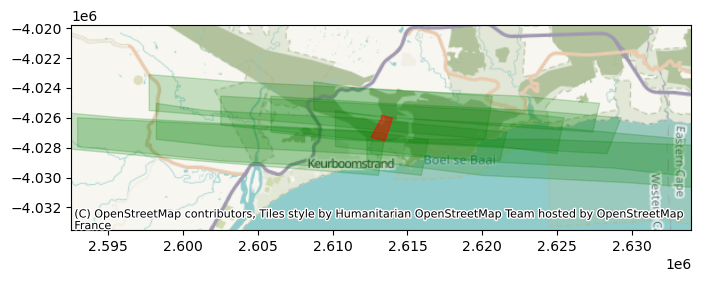

In [8]:
gdf = convert_list_gdf(granules)
ax = gdf.to_crs(epsg=3857).plot(figsize=(8, 6), alpha=0.2, facecolor="g",
                                edgecolor="g")
poly.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, facecolor="r",  edgecolor="r")
ax.set_xlim(xmin-20000, xmax+20000)
ax.set_ylim(ymin-6000, ymax+6000)
cx.add_basemap(ax)

## Download LVIS L2A files

In [9]:
downloaded_files = earthaccess.download(granules, local_path="data")

 Getting 9 granules, approx download size: 1.13 GB


QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

Earthaccess download uses a parallel downloading feature so all the files are downloaded efficiently. It also avoids duplicated downloads if a file has already been downloaded previously to the local path.

## Read LVIS L2A Files
LVIS L2A files are have a number of lines as header. Let's define a python function to read the number of header rows.

In [10]:
def get_line_number(filename):
    """find number of header rows in LVIS L2A"""
    count = 0
    with open(filename, encoding="utf-8") as f:
        for line in f:
            if line.startswith("#"):
                count = count + 1
            else:
                return count

Now, we can read the LVIS L2A files we downloaded into a pandas dataframe.

In [12]:
lvis_l2a = []
for f in glob('data/LVISF2*'):
    h_no = get_line_number(f)
    lvis_l2a.append(pd.read_csv(f, skiprows=h_no, header=None, sep='\s+'))
lvis_l2a_df = pd.concat(lvis_l2a)
lvis_l2a_df.columns = linecache.getline(f, h_no).split()[1:]

Let's convert pandas dataframe into geopandas.

In [13]:
lvis_l2a_gdf = gpd.GeoDataFrame(
    lvis_l2a_df, geometry=gpd.points_from_xy(lvis_l2a_df.GLON, lvis_l2a_df.GLAT), 
    crs="EPSG:4326")

lvis_l2a_subset_gdf = lvis_l2a_gdf[lvis_l2a_gdf['geometry'].within(poly.geometry[0])]  

The dataset uses WGS-84 Ellipsoid as geographic coordinates.

The data structure of LVIS Bioscape campaign is described [here](https://lvis.gsfc.nasa.gov/Data/Data_Structure/DataStructure_LDS205.html). The column `RH100` provides tree top heights.

The above extend beyond the subset area. Let's subset and plot canopy heights.

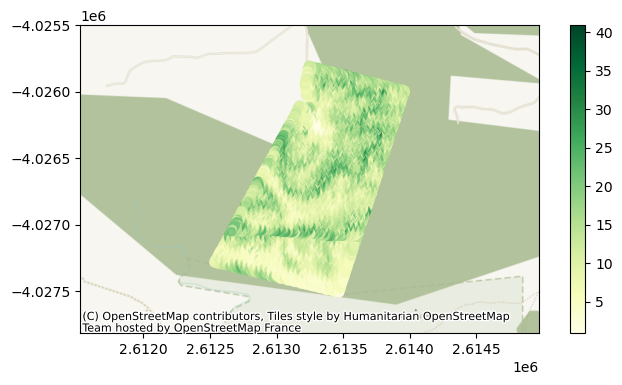

In [14]:
ax = lvis_l2a_subset_gdf.to_crs(epsg=3857).plot(figsize=(8, 4), 
                                                column="RH100", legend=True,
                                                alpha=0.5, cmap='YlGn')
ax.set_xlim(xmin-1000, xmax+1000)
ax.set_ylim(ymin-300, ymax+300)
cx.add_basemap(ax)